Data Preprocessing

In [53]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading datasets
drones_dataset = datasets.ImageFolder(root=r'D:\Python\CS726_Project\archive\BirdVsDrone\Drone', transform=transform)
birds_dataset = datasets.ImageFolder(root=r'D:\Python\CS726_Project\archive\BirdVsDrone\Bird', transform=transform)

# Creating data loaders
drones_loader = DataLoader(drones_dataset, batch_size=128, shuffle=True)
birds_loader = DataLoader(birds_dataset, batch_size=128, shuffle=True)




Discriminator and Generator

In [54]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Project and reshape
            nn.Linear(100, 256*8*8),
            nn.BatchNorm1d(256*8*8),
            nn.LeakyReLU(True),
            nn.Unflatten(1, (256, 8, 8)),
            
            # Upsampling to 16x16
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(True),
            
            # Upsampling to 32x32
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            
            # Upsampling to 64x64
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(256*8*8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img)


loss function and optimizers

In [55]:
import torch.optim as optim

# Initialize the GAN
generator = Generator()
discriminator = Discriminator()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(drones_loader):
        
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=imgs.device)
        fake = torch.zeros(imgs.size(0), 1, device=imgs.device)
        
        # Configure input
        real_imgs = imgs.to(imgs.device)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = torch.randn(imgs.size(0), 100, device=imgs.device)
        
        # Generate a batch of images
        gen_imgs = generator(z)
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(drones_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


[Epoch 0/20] [Batch 0/12] [D loss: 0.7620980739593506] [G loss: 0.5023857355117798]
[Epoch 0/20] [Batch 1/12] [D loss: 0.5997985601425171] [G loss: 0.9143087267875671]
[Epoch 0/20] [Batch 2/12] [D loss: 0.46122151613235474] [G loss: 0.9578397870063782]
[Epoch 0/20] [Batch 3/12] [D loss: 0.36301544308662415] [G loss: 1.1093107461929321]
[Epoch 0/20] [Batch 4/12] [D loss: 0.2954946756362915] [G loss: 1.4261482954025269]
[Epoch 0/20] [Batch 5/12] [D loss: 0.22780568897724152] [G loss: 1.5791337490081787]
[Epoch 0/20] [Batch 6/12] [D loss: 0.19129110872745514] [G loss: 1.7587738037109375]
[Epoch 0/20] [Batch 7/12] [D loss: 0.16755449771881104] [G loss: 1.9577438831329346]
[Epoch 0/20] [Batch 8/12] [D loss: 0.15362682938575745] [G loss: 2.049393653869629]
[Epoch 0/20] [Batch 9/12] [D loss: 0.09352094680070877] [G loss: 2.1081347465515137]
[Epoch 0/20] [Batch 10/12] [D loss: 0.0996275320649147] [G loss: 2.6430904865264893]
[Epoch 0/20] [Batch 11/12] [D loss: 0.11027667671442032] [G loss: 2.6

OOD

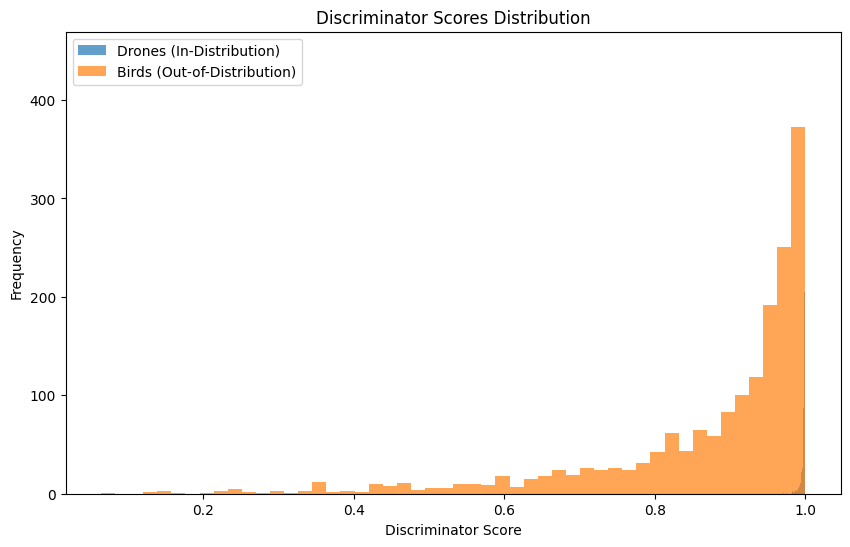

In [58]:
import torch

# Assuming 'discriminator' is your trained discriminator model
# and 'drones_loader' and 'birds_loader' are your data loaders

def collect_discriminator_scores(loader):
    scores = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(next(discriminator.parameters()).device)  # ensure images are on the same device as the model
            output = discriminator(images)
            scores.extend(output.flatten().cpu().numpy())  # Flatten the outputs and move them to CPU
    return scores

# Collect scores
drones_scores = collect_discriminator_scores(drones_loader)
birds_scores = collect_discriminator_scores(birds_loader)

import matplotlib.pyplot as plt

# Create histograms of the scores
plt.figure(figsize=(10, 6))
plt.hist(drones_scores, bins=50, alpha=0.7, label='Drones (In-Distribution)')
plt.hist(birds_scores, bins=50, alpha=0.7, label='Birds (Out-of-Distribution)')
plt.title('Discriminator Scores Distribution')
plt.xlabel('Discriminator Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [59]:
with torch.no_grad():
    for images, _ in birds_loader:
        #images = images.to(device)
        output = discriminator(images)
        print("Discriminator scores for OOD samples: ", output.mean().item())


Discriminator scores for OOD samples:  0.8521465063095093
Discriminator scores for OOD samples:  0.9076335430145264
Discriminator scores for OOD samples:  0.8755640983581543
Discriminator scores for OOD samples:  0.9442972540855408
Discriminator scores for OOD samples:  0.8646399974822998
Discriminator scores for OOD samples:  0.8459175229072571
Discriminator scores for OOD samples:  0.8772190809249878
Discriminator scores for OOD samples:  0.9013392329216003
Discriminator scores for OOD samples:  0.8818657398223877
Discriminator scores for OOD samples:  0.8202158212661743
Discriminator scores for OOD samples:  0.8231337070465088
Discriminator scores for OOD samples:  0.9016602039337158
Discriminator scores for OOD samples:  0.8988032341003418
Discriminator scores for OOD samples:  0.878281831741333
